In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# import pickle as pk
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim
# from torch.distributions import MultivariateNormal
# from torch.distributions import Normal
root_dir = '/mnt/home/spandey/ceph/AR_NPE/'
os.chdir(root_dir)
# import colossus
import sys, os
# append the root_dir to the path
sys.path.append(root_dir)
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
# from tqdm import tqdm
# import pyyaml
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
    
import yaml

# autoreload modules
%load_ext autoreload
%autoreload 2



In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl


In [3]:
# run_config_name = sys.argv[1]
run_config_name = 'run_test_128_condFPM_uniformcic_fof_lgMmin5e13_wL2norm_highknots.yaml'

with open("/mnt/home/spandey/ceph/AR_NPE/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)






In [4]:
config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
subsel_highM1 = config_sims['subsel_highM1']
nsubsel = config_sims['nsubsel']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
K_M1 = config_net['K_M1']
B_M1 = config_net['B_M1']
nflows_M1_NSF = config_net['nflows_M1_NSF']

K_Mdiff = config_net['K_Mdiff']
B_Mdiff = config_net['B_Mdiff']
nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

base_dist_Ntot = config_net['base_dist_Ntot']
if base_dist_Ntot == 'None':
    base_dist_Ntot = None
base_dist_M1 = config_net['base_dist_M1']
base_dist_Mdiff = config_net['base_dist_Mdiff']
ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    ninp = len(z_all_FP)
elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp

df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, ind_subsel_train = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_highM1=subsel_highM1, nsubsel=nsubsel
    )

# # Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax
    )

if cond_sim == 'fastpm':
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, ind_subsel_train_FP = load_density_halo_data_NGP(
        ji_array, ns_d, nb, nf, nc, z_all_FP, ns_h, stype=stype,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm', subsel_highM1=subsel_highM1, ind_subsel=ind_subsel_train
        )

    # # Prepare the density and halo data
    return_dict_train_FP = prep_density_halo_cats_batched(
        df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, nsims=nsims_per_batch,
        nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
        )
else:
    return_dict_train_FP = None






In [5]:
# len(ind_subsel_train_FP), len(ind_subsel_train)
# return_dict_train.keys()
# df_d_all_train.shape
ji_array




array([0, 1])

In [6]:
# return_dict_train['df_d_all'].shape, return_dict_train_FP['df_d_all'].shape
# return_dict_train['M_halos_all_sort_norm'].shape, return_dict_train_FP['M_halos_all_sort_norm'].shape
return_dict_train['M_diff_halos_all_norm_masked'].shape



(1, 1024, 4096, 3)

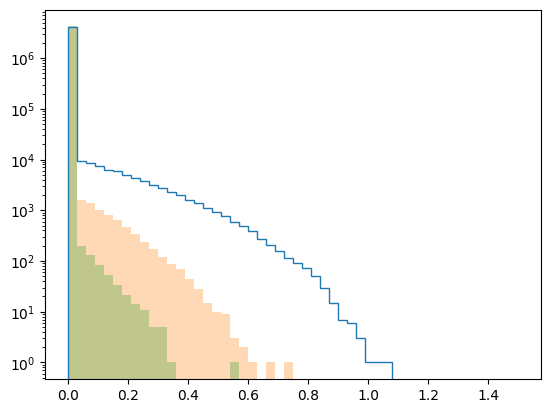

In [7]:
pl.figure()
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,0].flatten(), bins=50, range=(0,1.5), histtype='step', label='z=0')
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,1].flatten(), bins=50, range=(0,1.5), alpha=0.3)
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,2].flatten(), bins=50, range=(0,1.5), alpha=0.3)
pl.yscale('log')


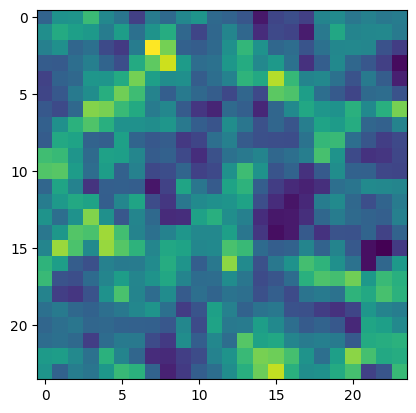

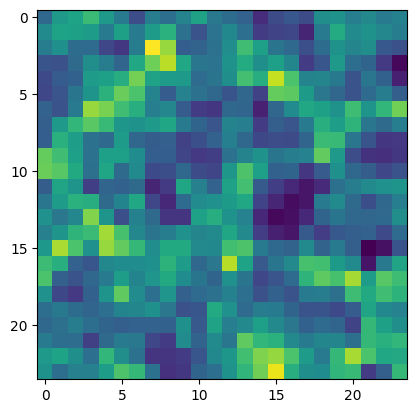

In [8]:
indp = 109

pl.figure()
pl.imshow(return_dict_train['df_d_all'][0,indp, 0, 16, :, :])
pl.figure()
pl.imshow(return_dict_train_FP['df_d_all'][0,indp, 0, 16, :, :])



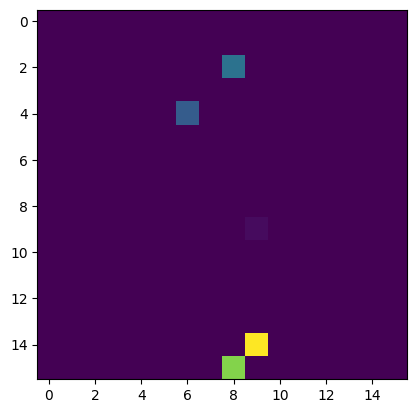

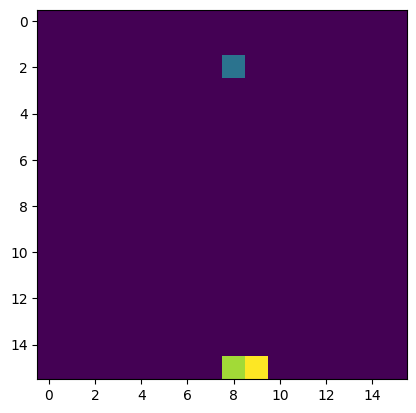

In [9]:
indp = 10
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
pl.figure()
pl.imshow(return_dict_train['M_halos_all_sort_norm'][0,indp,:, 0].reshape(16,16,16)[8,:,:])
pl.figure()
pl.imshow(return_dict_train_FP['M_halos_all_sort_norm'][0,indp,:,0].reshape(16,16,16)[8,:,:])



In [6]:
lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


# num_cond_Ntot = num_cond
# model_Ntot = SumGaussModel(
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Ntot,
#     ngauss=return_dict_train['ngauss_Nhalo'],
#     mu_all=return_dict_train['mu_all'],
#     sig_all=return_dict_train['sig_all'],
#     base_dist=base_dist_Ntot   
#     )

# num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

# model_M1 = NSF_M1_CNNcond(
#     K=K_M1,
#     B=B_M1,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_M1,
#     nflows=nflows_M1_NSF,
#     base_dist=base_dist_M1,
#     ngauss=ngauss_M1,
#     lgM_rs_tointerp=lgM_rescaled,
#     hmf_pdf_tointerp=hmf_pdf,
#     hmf_cdf_tointerp=hmf_cdf    
#     )

# ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# num_cond_Mdiff = num_cond + 2
# model_Mdiff = NSF_Mdiff_CNNcond(
#     dim=ndim_diff,
#     K=K_Mdiff,
#     B=B_Mdiff,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Mdiff,
#     nflows=nflows_Mdiff_NSF,
#     base_dist=base_dist_Mdiff,
#     mu_pos=True
#     )

# ndim = ndim_diff + 1
# model = COMBINED_Model(
#     None,
#     model_Mdiff,
#     # None,
#     model_M1,
#     model_Ntot,
#     ndim,
#     ksize,
#     ns_d,
#     ns_h,
#     nb,
#     ninp,
#     nfeature_cnn,
#     nout_cnn,
#     layers_types=layers_types,
#     act='tanh',
#     padding='valid',
#     sep_Ntot_cond=True,
#     sep_M1_cond=True,
#     sep_Mdiff_cond=True,
#     num_cond_Ntot = num_cond_Ntot,
#     num_cond_M1 = num_cond_M1,
#     num_cond_Mdiff = num_cond_Mdiff
#     )

# model.to(dev)

# print()


In [7]:
# base_dist_Ntot


In [8]:
from torch.utils.data import DataLoader, Dataset
# class LoadCustomData(Dataset):
#     def __init__(self, return_dict, return_dict_FP, all_gpu=False):
#         if return_dict_FP is not None:
#             self.cond_tensor = torch.Tensor(np.array(return_dict_FP['df_d_all']))
#             cond_nsh = np.moveaxis(np.array(return_dict_FP['df_d_all_nsh']), 2, 5)
#             self.cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
#         else:
#             self.cond_tensor = torch.Tensor(np.array(return_dict['df_d_all']))
#             cond_nsh = np.moveaxis(np.array(return_dict['df_d_all_nsh']), 2, 5)
#             self.cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

#         self.mask_tensor_M1_train = torch.Tensor(np.array(return_dict['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
#         self.mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict['mask_M_diff']))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_diff)

#         self.X_M1 = torch.Tensor((np.array(return_dict['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         self.X_Nhalo = torch.Tensor(np.array(return_dict['Nhalo_train_mg_arr'])).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         self.X_Mdiff = torch.Tensor(np.array(return_dict['M_diff_halos_all_norm_masked'])).reshape(-1, nsims_per_batch * (nax_h**3),ndim_diff)
#         self.Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)

#         if return_dict_FP is not None:
#             self.mask_tensor_M1_train_FP = torch.Tensor(np.array(return_dict_FP['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
#             self.X_M1_FP = torch.Tensor((np.array(return_dict_FP['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         else:
#             self.mask_tensor_M1_train_FP = None
#             self.X_M1_FP = None
#         if all_gpu:
            # self.cond_tensor = self.cond_tensor.cuda(dev)
            # self.cond_tensor_nsh = self.cond_tensor_nsh.cuda(dev)
            # self.mask_tensor_M1_train = self.mask_tensor_M1_train.cuda(dev)
            # self.mask_tensor_Mdiff_train = self.mask_tensor_Mdiff_train.cuda(dev)
            # self.X_M1 = self.X_M1.cuda(dev)
            # self.X_Nhalo = self.X_Nhalo.cuda(dev)
            # self.X_Mdiff = self.X_Mdiff.cuda(dev)
            # self.Nhalos_truth_tensor = self.Nhalos_truth_tensor.cuda(dev)
            # if return_dict_FP is not None:
            #     self.mask_tensor_M1_train_FP = self.mask_tensor_M1_train_FP.cuda(dev)
            #     self.X_M1_FP = self.X_M1_FP.cuda(dev)

#     def __len__(self):
#         return len(self.cond_tensor)

#     def __getitem__(self, idx):
#         cond_tensor = (self.cond_tensor[idx,...])
#         cond_tensor_nsh = self.cond_tensor_nsh[idx,...]
#         mask_tensor_M1_train = self.mask_tensor_M1_train[idx,...]
#         mask_tensor_Mdiff_train =self.mask_tensor_Mdiff_train[idx,...]
#         X_M1 = self.X_M1[idx,...]
#         X_Nhalo = self.X_Nhalo[idx,...]
#         X_Mdiff = self.X_Mdiff[idx,...]
#         Nhalos_truth_tensor = self.Nhalos_truth_tensor[idx,...]
#         if self.mask_tensor_M1_train_FP is not None:
#             mask_tensor_M1_train_FP = self.mask_tensor_M1_train_FP[idx,...]
#             X_M1_FP = self.X_M1_FP[idx,...]
#         else:
#             mask_tensor_M1_train_FP = torch.Tensor([-9999])
#             X_M1_FP = torch.Tensor([-9999])

#         return (cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, X_Nhalo,
#                  X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP)


ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]

if return_dict_train_FP is not None:
    cond_tensor = torch.Tensor(np.array(return_dict_train_FP['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train_FP['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
else:
    cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

mask_tensor_M1_train = torch.Tensor(np.array(return_dict_train['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict_train['mask_M_diff']))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_diff)

X_M1 = torch.Tensor((np.array(return_dict_train['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Nhalo = torch.Tensor(np.array(return_dict_train['Nhalo_train_mg_arr'])).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Mdiff = torch.Tensor(np.array(return_dict_train['M_diff_halos_all_norm_masked'])).reshape(-1, nsims_per_batch * (nax_h**3),ndim_diff)
Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)

if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = torch.Tensor(np.array(return_dict_train_FP['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
    X_M1_FP = torch.Tensor((np.array(return_dict_train_FP['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
else:
    mask_tensor_M1_train_FP = None
    X_M1_FP = None

    
cond_tensor = cond_tensor.cuda(dev)
cond_tensor_nsh = cond_tensor_nsh.cuda(dev)
mask_tensor_M1_train = mask_tensor_M1_train.cuda(dev)
mask_tensor_Mdiff_train = mask_tensor_Mdiff_train.cuda(dev)
X_M1 = X_M1.cuda(dev)
X_Nhalo = X_Nhalo.cuda(dev)
X_Mdiff = X_Mdiff.cuda(dev)
Nhalos_truth_tensor = Nhalos_truth_tensor.cuda(dev)
if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = mask_tensor_M1_train_FP.cuda(dev)
    X_M1_FP = X_M1_FP.cuda(dev)
    
    




In [9]:
# X_Nhalo.shape, cond_tensor_nsh.shape
np.array(return_dict_train['N_halos_all']).shape, cond_nsh.shape, np.array(return_dict_train['M1_halos_all_norm']).shape

Nhalos_3d = np.array(return_dict_train['N_halos_all']).reshape(-1, nsims_per_batch, nax_h, nax_h, nax_h)
Mhalos_3d = np.array(return_dict_train['M1_halos_all_norm']).reshape(-1, nsims_per_batch, nax_h, nax_h, nax_h)
delta_m_3d = cond_nsh[...,0]




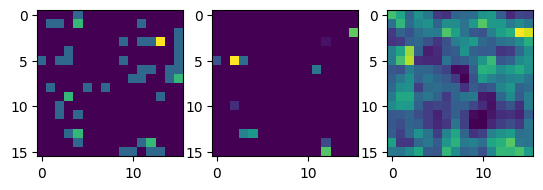

In [10]:
# make a three panel plot
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline
indsim = 300
pl.figure()
pl.subplot(131)
pl.imshow(Nhalos_3d[0,indsim,0,...])
# pl.colorbar()
pl.subplot(132)
pl.imshow(Mhalos_3d[0,indsim,0,...])
# pl.colorbar()
pl.subplot(133)
pl.imshow(delta_m_3d[0,indsim,0,...])
# pl.colorbar()


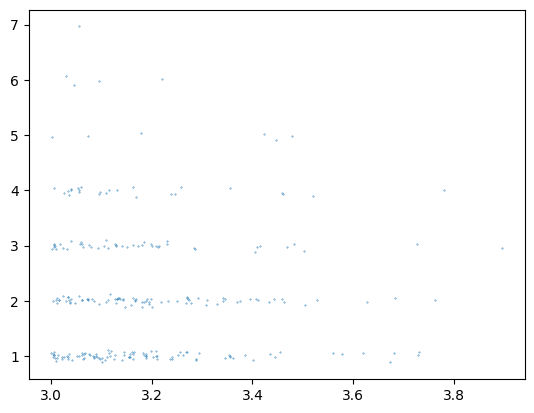

In [11]:

delta_m = cond_tensor_nsh[0,:,0].cpu().numpy()
Nhalo = X_Nhalo[0,:,0].cpu().numpy()
indsel = np.where((delta_m > 3) & (delta_m < 100))[0]
pl.figure()
pl.scatter(delta_m[indsel], Nhalo[indsel], s=0.1)


In [16]:
np.amin(delta_m), np.amax(delta_m), np.amin(Nhalo), np.amax(Nhalo)



(-3.079246, 3.895638, 0.7233349, 10.037307)

In [12]:
with open("/mnt/home/spandey/ceph/AR_NPE/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)

config_train = config['train_settings']
batch_size = config_train['batch_size_DL']
all_gpu = config_train['all_gpu']

try:
    L2norm_Ntothist = config_train['L2norm_Ntothist']
except:
    L2norm_Ntothist = False

try:
    L2norm_M1hist = config_train['L2norm_M1hist']
except:
    L2norm_M1hist = False

nflows_train = config_train['nflows_train']

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST_SUBSEL_TEST_FINALS_SIMPLE_BATCHED_model_save_nsim' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim + \
#                             '_nsd' + str(ns_d) + '_nc' + str(nc) + '_nsh' + str(ns_h) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train) + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST2_SUBSEL_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST2_NOSUBSEL_plexp_ns_' + str(len(ji_array)) + \
                            '_cond_sim_' + cond_sim  \
                            + '_nc' + str(nc) + '_mass_' + mass_type + \
                            '_KM1_' + str(K_M1) + \
                            '_stype_' + stype + \
                            '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

print(save_bestfit_model_dir, os.path.exists(save_bestfit_model_dir))
# make directory if it doesn't exist
import os
if not os.path.exists(save_bestfit_model_dir):
    os.makedirs(save_bestfit_model_dir)

start_with_bestfit = config_train['start_with_bestfit']

# if start_with_bestfit:
#     try:
#         print('loading bestfit model')
#         bestfit_model = (torch.load(save_bestfit_model_name))
#         model.load_state_dict(bestfit_model['state_dict'])
#         optimizer.load_state_dict(bestfit_model['optimizer'])
#         scheduler.load_state_dict(bestfit_model['scheduler'])
#         loss_min = bestfit_model['loss_min']
#         loss = bestfit_model['loss']
#         lr = bestfit_model['lr']
#         epoch_tot_counter = bestfit_model['epoch_tot_counter']
#         for g in optimizer.param_groups:
#             # g['lr'] = lr
#             g['lr'] = 0.01          

#     except:
#         print('no bestfit model found, running new')
#         pass
#         epoch_tot_counter = 0


# dataset = LoadCustomData(return_dict_train, return_dict_train_FP, all_gpu=all_gpu)
# dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=1 - all_gpu, num_workers=1)




/mnt/home/spandey/ceph/AR_NPE/TRAIN_ROCKSTAR_FOF/FINALTEST2_NOSUBSEL_plexp_ns_2_cond_sim_fastpm_nc4_mass_fof_KM1_10_stype_uniform_cic_L2normNtothist_False_L2normM1hist_False True


In [13]:
# print(loss)


In [14]:
nepochs_Ntot_only = config_train['nepochs_Ntot_only']
nepochs_Ntot_M1_only = config_train['nepochs_Ntot_M1_only']
nepochs_all = config_train['nepochs_all']


# nepochs_array = [nepochs_Ntot_only, nepochs_Ntot_M1_only, nepochs_all]
# train_Ntot_array = [1, 1, 1]
# train_M1_array = [0, 1, 1 ]
# train_Mdiff_array = [0, 0, 1]

nepochs_array = [nepochs_Ntot_only]
train_Ntot_array = [1]
train_M1_array = [0]
train_Mdiff_array = [0]

for jf in range(nflows_train):
# for jf in np.arange(7,16):    
    epoch_tot_counter = 0
    num_cond_Ntot = num_cond
    
    model_Ntot = SumGaussModel(
        hidden_dim=hidden_dim_MAF,
        num_cond=num_cond_Ntot,
        ngauss=return_dict_train['ngauss_Nhalo'],
        mu_all=return_dict_train['mu_all'],
        sig_all=return_dict_train['sig_all'],
        base_dist=base_dist_Ntot   
        )

    num_cond_M1 = num_cond + 1
    # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
    if cond_sim == 'fastpm':
        num_cond_M1 += 2

    model_M1 = NSF_M1_CNNcond(
        K=K_M1,
        B=B_M1,
        hidden_dim=hidden_dim_MAF,
        num_cond=num_cond_M1,
        nflows=nflows_M1_NSF,
        base_dist=base_dist_M1,
        ngauss=ngauss_M1,
        lgM_rs_tointerp=lgM_rescaled,
        hmf_pdf_tointerp=hmf_pdf,
        hmf_cdf_tointerp=hmf_cdf    
        )

    ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
    num_cond_Mdiff = num_cond + 2
    model_Mdiff = NSF_Mdiff_CNNcond(
        dim=ndim_diff,
        K=K_Mdiff,
        B=B_Mdiff,
        hidden_dim=hidden_dim_MAF,
        num_cond=num_cond_Mdiff,
        nflows=nflows_Mdiff_NSF,
        base_dist=base_dist_Mdiff,
        mu_pos=True
        )

    ndim = ndim_diff + 1
    model = COMBINED_Model(
        None,
        model_Mdiff,
        # None,
        model_M1,
        model_Ntot,
        ndim,
        ksize,
        ns_d,
        ns_h,
        nb,
        ninp,
        nfeature_cnn,
        nout_cnn,
        layers_types=layers_types,
        act='tanh',
        padding='valid',
        sep_Ntot_cond=True,
        sep_M1_cond=True,
        sep_Mdiff_cond=True,
        num_cond_Ntot = num_cond_Ntot,
        num_cond_M1 = num_cond_M1,
        num_cond_Mdiff = num_cond_Mdiff
        )

    model.to(dev)

    print()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_all_it = []
    loss_min = 1e20
    epoch_tot_counter = 0
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=200, verbose=True, cooldown=200, min_lr=1e-8)



    save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)
    for jn in (range(len(nepochs_array))):
        loss_min = 1e20
        torch.cuda.empty_cache()
        ninit = 0
        nepochs = nepochs_array[jn]
        if nepochs > 0:
            train_Ntot = train_Ntot_array[jn]
            train_M1 = train_M1_array[jn]
            train_Mdiff = train_Mdiff_array[jn]

            if jn > 0:
                print('loading bestfit model')
                bestfit_model = (torch.load(save_bestfit_model_name))
                model.load_state_dict(bestfit_model['state_dict'])
                optimizer.load_state_dict(bestfit_model['optimizer'])
                scheduler.load_state_dict(bestfit_model['scheduler'])
                # loss_min = bestfit_model['loss_min']
                loss = bestfit_model['loss']
                lr = bestfit_model['lr']
                for g in optimizer.param_groups:
                    g['lr'] = learning_rate

            for jt in tqdm(range(nepochs)):
                # for jd in range(len(dataloader)):
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                cond_tensor_jd, cond_tensor_nsh_jd, mask_tensor_M1_train_jd, mask_tensor_Mdiff_train_jd, X_M1_jd, \
                    X_Nhalo_jd, X_Mdiff_jd, Nhalos_truth_tensor_jd, mask_tensor_M1_train_FP_jd, X_M1_FP_jd = cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, \
                            X_Nhalo, X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP

                if cond_sim == 'quijote':               
                    mask_tensor_M1_train_FP_jd = None
                    X_M1_FP_jd = None
                
                torch.cuda.empty_cache()
                # if 1-all_gpu:
                cond_tensor_jd = cond_tensor_jd.cuda(dev)
                cond_tensor_nsh_jd = cond_tensor_nsh_jd.cuda(dev)
                mask_tensor_M1_train_jd = mask_tensor_M1_train_jd.cuda(dev)
                mask_tensor_Mdiff_train_jd = mask_tensor_Mdiff_train_jd.cuda(dev)
                X_M1_jd = X_M1_jd.cuda(dev)
                X_Nhalo_jd = X_Nhalo_jd.cuda(dev)
                X_Mdiff_jd = X_Mdiff_jd.cuda(dev)
                Nhalos_truth_tensor_jd = Nhalos_truth_tensor_jd.cuda(dev)
                if mask_tensor_M1_train_FP_jd is not None:
                    mask_tensor_M1_train_FP_jd = mask_tensor_M1_train_FP_jd.cuda(dev)
                    X_M1_FP_jd = X_M1_FP_jd.cuda(dev)
                torch.cuda.empty_cache()
                                
                loss = model(
                    X_Mdiff_jd,
                    X_M1_jd,
                    X_Nhalo_jd,
                    cond_x=cond_tensor_jd,
                    cond_x_nsh=cond_tensor_nsh_jd,
                    mask_Mdiff_truth_all=mask_tensor_Mdiff_train_jd,
                    mask_M1_truth_all=mask_tensor_M1_train_jd,
                    Nhalos_truth_all=Nhalos_truth_tensor_jd,
                    use_Ntot_samples=False,
                    use_M1_samples=False,
                    train_Ntot=train_Ntot,
                    train_M1=train_M1,
                    train_Mdiff=train_Mdiff,
                    # x_Mdiff_FP=X_Mdiff_FP,
                    x_M1_FP=X_M1_FP_jd,
                    # x_Ntot_FP=X_Nhalo_FP,
                    # Nhalos_truth_all_FP=Nhalos_truth_tensor_FP,
                    # mask_Mdiff_truth_all_FP=mask_tensor_Mdiff_train_FP,
                    mask_M1_truth_all_FP=mask_tensor_M1_train_FP_jd,
                    L2norm_Ntothist=L2norm_Ntothist,
                    L2norm_M1hist=L2norm_M1hist        
                    )

                loss.backward()
                optimizer.step()
                scheduler.step(loss)
                epoch_tot_counter += 1
                if (np.mod(jt, int(nepochs / 10)) == 0) or (jt == nepochs - 1):
                    if float(loss.cpu().detach().numpy()) < loss_min:
                        loss_min = float(loss.cpu().detach().numpy())
                        print('saving bf at:', ', with loss:', np.round(loss_min, 5), ', at epoch:', jt, 
                            'learning rate:', optimizer.param_groups[0]['lr'], ', train_Ntot:', train_Ntot, 
                            'train_M1:', train_M1, ', train_Mdiff:', train_Mdiff, ', epoch_tot_counter:', epoch_tot_counter)
                        lr=optimizer.param_groups[0]['lr']
                        # print(loss_min, lr)
                        state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                                'scheduler': scheduler.state_dict(), 'loss':loss, 'lr':lr, 'epoch_tot_counter':epoch_tot_counter}

                        torch.save(
                            state, save_bestfit_model_name
                            )






  0%|          | 0/10000 [00:00<?, ?it/s]/mnt/home/spandey/ceph/.venv/lib/python3.9/site-packages/torch/nn/modules/conv.py:608: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv3d(
  0%|          | 1/10000 [00:01<3:25:06,  1.23s/it]

saving bf at: , with loss: -0.98705 , at epoch: 0 learning rate: 0.01 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


 10%|█         | 1001/10000 [03:51<33:51,  4.43it/s] 

saving bf at: , with loss: -1.20615 , at epoch: 1000 learning rate: 0.01 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1001


 20%|██        | 2001/10000 [07:40<30:15,  4.41it/s]  

saving bf at: , with loss: -1.20939 , at epoch: 2000 learning rate: 0.01 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2001


 31%|███       | 3052/10000 [11:42<25:40,  4.51it/s]  

Epoch 03052: reducing learning rate of group 0 to 5.0000e-03.


 40%|████      | 4001/10000 [15:20<22:48,  4.38it/s]

saving bf at: , with loss: -1.21172 , at epoch: 4000 learning rate: 0.005 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4001


 50%|█████     | 5001/10000 [19:09<18:42,  4.45it/s]

saving bf at: , with loss: -1.21191 , at epoch: 5000 learning rate: 0.005 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5001


 60%|██████    | 6001/10000 [22:59<15:02,  4.43it/s]

saving bf at: , with loss: -1.21223 , at epoch: 6000 learning rate: 0.005 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 6001


 80%|████████  | 8001/10000 [30:37<07:31,  4.42it/s]

saving bf at: , with loss: -1.21269 , at epoch: 8000 learning rate: 0.005 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 8001


 90%|█████████ | 9001/10000 [34:27<03:45,  4.44it/s]

saving bf at: , with loss: -1.21381 , at epoch: 9000 learning rate: 0.005 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 9001


100%|██████████| 10000/10000 [38:17<00:00,  4.35it/s]

saving bf at: , with loss: -1.21381 , at epoch: 9999 learning rate: 0.005 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 10000


In [8]:
# for jf in range(7):
#     save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)
#     bestfit_model = (torch.load(save_bestfit_model_name))
#     loss_min = bestfit_model['loss_min']
#     print(loss_min)

num_cond_Ntot = num_cond

model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=return_dict_train['ngauss_Nhalo'],
    mu_all=return_dict_train['mu_all'],
    sig_all=return_dict_train['sig_all'],
    base_dist=base_dist_Ntot   
    )

num_cond_M1 = num_cond + 1
# if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
if cond_sim == 'fastpm':
    num_cond_M1 += 2

model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_pdf,
    hmf_cdf_tointerp=hmf_cdf    
    )

ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
num_cond_Mdiff = num_cond + 2
model_Mdiff = NSF_Mdiff_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Mdiff,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )

ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Ntot_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    num_cond_Ntot = num_cond_Ntot,
    num_cond_M1 = num_cond_M1,
    num_cond_Mdiff = num_cond_Mdiff
    )

model.to(dev)

print()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_all_it = []
loss_min = 1e20
epoch_tot_counter = 0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=200, verbose=True, cooldown=200, min_lr=1e-8)

save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(0)
bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])
scheduler.load_state_dict(bestfit_model['scheduler'])
# loss_min = bestfit_model['loss_min']
loss = bestfit_model['loss']


In [9]:
print(loss)


tensor([-1.2101], device='cuda:0', requires_grad=True)


In [10]:
# print('loading bestfit model')
# bestfit_model = (torch.load(save_bestfit_model_name))
# model.load_state_dict(bestfit_model['state_dict'])
# optimizer.load_state_dict(bestfit_model['optimizer'])
# scheduler.load_state_dict(bestfit_model['scheduler'])
# loss_min = bestfit_model['loss_min']
# loss = bestfit_model['loss']
# lr = bestfit_model['lr']
# epoch_tot_counter = bestfit_model['epoch_tot_counter']
# for g in optimizer.param_groups:
#     g['lr'] = lr

# print(loss_min, epoch_tot_counter, lr)




In [15]:
import readfof
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
import yaml

print(loss_min, epoch_tot_counter, stype)

train_Ntot, train_M1, train_Mdiff = 1, 1, 1
# train_Ntot, train_M1, train_Mdiff = 1, 1, 0
# train_Ntot, train_M1, train_Mdiff = 1, 0, 0
isim_start = 1
isim_end = 2
isim_all = np.arange(isim_start, isim_end).astype(int)
for ji in range(len(isim_all)):
    saved_all_jsim = {}
    # now we load the test data
    isim = isim_all[ji]
    print('DOING SIM NUMBER:' + str(isim))
    nstart = 0
    nsims_test = 512
    df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test, _ = load_density_halo_data_NGP(
        [isim], ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
        stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr
        )

    if cond_sim == 'fastpm':
        df_d_all_test_FP, df_d_all_nsh_test_FP, df_Mh_all_test_FP, df_Nh_test_FP, _ = load_density_halo_data_NGP(
            [isim], ns_d, nb, nf, nc, z_all_FP, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm',
            stype=stype
            )

    # things are too big to load all at once, so we load in batches
    nq = nb**3 // nsims_test
    save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_M1_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    save_subvol_Mdiff_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    mask_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))

    # nfeatures_M1_tot = 20
    # cond_inp_M1_all = np.zeros((nb**3, nax_h, nax_h, nax_h, nfeatures_M1_tot))
    density_out_M1_loc_all_pad = np.zeros((nb**3, nax_h+6, nax_h+6, nax_h+6))
    density_out_M1_loc_all = np.zeros((nb**3, nax_h, nax_h, nax_h))

    nscount = 0
    for jq in range(nq):
        # Load the density data


        # Prepare the density and halo data
        return_dict_test = prep_density_halo_cats(
            df_d_all_test,
            df_d_all_nsh_test,
            df_Mh_all_test,
            df_Nh_test,
            nsims=nsims_test,
            nstart=nscount,
            Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax
            )
        
        if cond_sim == 'fastpm':
            return_dict_test_FP = prep_density_halo_cats(
                df_d_all_test_FP,
                df_d_all_nsh_test_FP,
                df_Mh_all_test_FP,
                df_Nh_test_FP,
                nsims=nsims_test,
                nstart=nscount,
                Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
                )    

        if cond_sim == 'fastpm':
            cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test_FP['df_d_all']]))).cuda(dev)
            cond_nsh_test = np.moveaxis(return_dict_test_FP['df_d_all_nsh'], 1, 4)
            cond_nsh_test = np.array([cond_nsh_test])
            cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
        else:
            cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test['df_d_all']]))).cuda(dev)
            cond_nsh_test = np.moveaxis(return_dict_test['df_d_all_nsh'], 1, 4)
            cond_nsh_test = np.array([cond_nsh_test])
            cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)

        mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
        mask_tensor_Mdiff_test = torch.Tensor(
            (return_dict_test['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            ).cuda(dev)

        X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
        X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
        X_Mdiff_test = torch.Tensor(
            return_dict_test['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            ).cuda(dev)
        Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                        1)))).cuda(dev)
        
        if cond_sim == 'fastpm':
            mask_tensor_M1_test_FP = torch.Tensor(np.copy(return_dict_test_FP['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
            # mask_tensor_Mdiff_test_FP = torch.Tensor(
            #     (return_dict_test_FP['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            #     ).cuda(dev)

            X_M1_test_FP = torch.Tensor((return_dict_test_FP['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
            X_Nhalo_test_FP = torch.Tensor(return_dict_test_FP['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
            # X_Mdiff_test_FP = torch.Tensor(
            #     return_dict_test_FP['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            #     ).cuda(dev)
            Nhalos_truth_tensor_test_FP = torch.Tensor(((return_dict_test_FP['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                            1)))).cuda(dev)
        else:
            mask_tensor_M1_test_FP = None
            mask_tensor_Mdiff_test_FP = None
            X_M1_test_FP = None
            X_Nhalo_test_FP = None
            X_Mdiff_test_FP = None
            Nhalos_truth_tensor_test_FP = None

        Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, cond_inp_M1_test = model.inverse(
            cond_x=cond_tensor_test,
            cond_x_nsh=cond_tensor_nsh_test,
            use_truth_Nhalo=1-train_Ntot,
                use_truth_M1=1-train_M1,
                use_truth_Mdiff=1-train_Mdiff, 
            mask_Mdiff_truth=mask_tensor_Mdiff_test,
            mask_M1_truth=mask_tensor_M1_test,
            Nhalos_truth=X_Nhalo_test,
            M1_truth=X_M1_test,
            Mdiff_truth=X_Mdiff_test,
            train_Ntot=train_Ntot,
            train_M1=train_M1,
            train_Mdiff=train_Mdiff,
            x_M1_FP=X_M1_test_FP,   
            mask_M1_truth_all_FP=mask_tensor_M1_test_FP 
            )
        Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
        # print(Ntot_samp_test.shape)
        save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_M1[nscount:nscount + nsims_test,
                    ...] = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:,0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
        save_subvol_M1_truth[nscount:nscount + nsims_test,
                    ...] = (X_M1_test[0][:,0] * mask_tensor_M1_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)    
        # cond_inp_M1_all[nscount:nscount + nsims_test,
        #                ...] = cond_inp_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, nfeatures_M1_tot)
        # density_out_M1_loc_all_pad[nscount:nscount + nsims_test,...] = (cond_tensor_test[0,:,0,...].cpu().detach().numpy())
        # density_out_M1_loc_all[nscount:nscount + nsims_test,...] = (cond_nsh_test[0,...,0])

        save_subvol_Mdiff[nscount:nscount + nsims_test,
                        ...] = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        save_subvol_Mdiff_truth[nscount:nscount + nsims_test,
                        ...] = (X_Mdiff_test[0] * mask_tensor_Mdiff_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

        mask_subvol_Mtot_truth[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot_truth[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        
        cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
        # print(nscount, nscount + nsims_test)

        nscount += nsims_test
        torch.cuda.empty_cache()


    save_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot[...,
                            jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot *= mask_subvol_Mtot

    ind_less_Mmin = save_subvol_Mtot < Mmin
    ind_greater_Mmax = save_subvol_Mtot > Mmax
    save_subvol_Mtot[ind_less_Mmin] = 0.0
    save_subvol_Mtot[ind_greater_Mmax] = 0.0


    save_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot_truth[..., jd] = (save_subvol_M1_truth[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot_truth[...,
                            jd] = (save_subvol_Mtot_truth[..., jd - 1]) - (save_subvol_Mdiff_truth[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot_truth *= mask_subvol_Mtot_truth
                

    sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # load the halo data
    fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    df_h_subvol = pk.load(open(fname, 'rb'))
    # This has information on the halo mass for all the halos in the voxel
    df_Mh_all_truth = df_h_subvol['M_halos']
    df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # This has information on the number of halos in the voxel
    df_Nh_truth = df_h_subvol['N_halos']

    fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
    df_h_full = pk.load(open(fname, 'rb'))
    df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'], df_h_full['N_halos_combined']

    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1

    bin_cents = np.array(np.arange(Nmax + 1))
    bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
    bin_edges = np.insert(bin_edges,0, -0.5)
    bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
    saved_all_jsim['Nhalo_bin_cents'] = bin_cents
    saved_all_jsim['Nhalo_bin_edges'] = bin_edges

    delta_min_p, delta_max_p= -1.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_all, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_all, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_all_Nhalo'] = hist_truth_all
    saved_all_jsim['hist_samp_all_Nhalo'] = hist_samp_all
    print(hist_samp_all)
    print(hist_truth_all)

    delta_min_p, delta_max_p= -1.0, 0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_low, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_low, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_low_Nhalo'] = hist_truth_low
    saved_all_jsim['hist_samp_low_Nhalo'] = hist_samp_low

    delta_min_p, delta_max_p= 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_mid, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_mid, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_mid_Nhalo'] = hist_truth_mid
    saved_all_jsim['hist_samp_mid_Nhalo'] = hist_samp_mid

    delta_min_p, delta_max_p= 2.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_high, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_high, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_high_Nhalo'] = hist_truth_high
    saved_all_jsim['hist_samp_high_Nhalo'] = hist_samp_high


    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
    bin_cents_M = np.linspace(lgMmin, lgMmax, 20)[1:-1]
    bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
    delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
    bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
    bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] - delta_b)
    saved_all_jsim['Mhalo_bin_cents'] = bin_cents_M
    saved_all_jsim['Mhalo_bin_edges'] = bin_edges_M


    delta_min_p, delta_max_p = -1.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_all = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_all = np.zeros((4, len(bin_cents_M)))    
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_all[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_all[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_all_Mhalo'] = hist_M_truth_all
    saved_all_jsim['hist_samp_all_Mhalo'] = hist_M_samp_all

    delta_min_p, delta_max_p = -1.0, 0.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_low = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_low = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_low[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_low[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_low_Mhalo'] = hist_M_truth_low
    saved_all_jsim['hist_samp_low_Mhalo'] = hist_M_samp_low

    delta_min_p, delta_max_p = 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_mid = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_mid = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_mid[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_mid[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_mid_Mhalo'] = hist_M_truth_mid
    saved_all_jsim['hist_samp_mid_Mhalo'] = hist_M_samp_mid

    delta_min_p, delta_max_p = 2.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_high = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_high = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_high[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_high[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_high_Mhalo'] = hist_M_truth_high
    saved_all_jsim['hist_samp_high_Mhalo'] = hist_M_samp_high

    # # import pdb; pdb.set_trace()

    # # create empty arrays for Nhalos and M_halos
    # Nhalos = np.zeros((ns_h, ns_h, ns_h))
    # M_halos = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
    # M_halos_truth = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    # subvol_size = ns_h // nb

    # ind_cart_lin = {}
    # ind_lin_cart = {}
    # jc = 0
    # from tqdm import tqdm
    # for jx in tqdm(range(nb)):
    #     for jy in range(nb):
    #         for jz in range(nb):
    #             # get the sub-cube
    #             ind_lin_cart[(jx, jy, jz)] = jc
    #             ind_cart_lin[jc] = [jx, jy, jz]
    #             jc += 1
                

    # # iterate over subvolumes
    # jc = 0
    # for jx in range(nb):
    #     for jy in range(nb):
    #         for jz in range(nb):
    #             Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
    #                 jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[ind_lin_cart[(jx, jy, jz)]]

    #             M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
    #                     jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[ind_lin_cart[(jx, jy, jz)]]
                
                
    #             jc += 1
                
                
    
    # # create empty arrays for Nhalos and M_halos
    # Nhalos_truth_recomb = np.zeros((ns_h, ns_h, ns_h))
    # M_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    # subvol_size = ns_h // nb

    # ind_cart_lin = {}
    # ind_lin_cart = {}
    # jc = 0
    # from tqdm import tqdm
    # for jx in tqdm(range(nb)):
    #     for jy in range(nb):
    #         for jz in range(nb):
    #             # get the sub-cube
    #             ind_lin_cart[(jx, jy, jz)] = jc
    #             ind_cart_lin[jc] = [jx, jy, jz]
    #             jc += 1
                

    # # iterate over subvolumes
    # jc = 0
    # for jx in range(nb):
    #     for jy in range(nb):
    #         for jz in range(nb):
    #             Nhalos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
    #                 jz * subvol_size:(jz + 1) * subvol_size] = df_Nh_truth[ind_lin_cart[(jx, jy, jz)]]

    #             M_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
    #                     jz * subvol_size:(jz + 1) * subvol_size, :] = df_Mh_all_truth[ind_lin_cart[(jx, jy, jz)]]
                
                
    #             jc += 1
                

    # # create the meshgrid
    # zv = 0.0
    # av = 1. / (1 + zv)
    # xall = (np.linspace(0, 1000, ns_h + 1))
    # xarray = av * 0.5 * (xall[1:] + xall[:-1])
    # yarray = np.copy(xarray)
    # zarray = np.copy(xarray)
    # x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')


    # # create the meshgrid
    # zv = 0.0
    # av = 1. / (1 + zv)
    # xall = (np.linspace(0, 1000, ns_h + 1))
    # xarray = av * 0.5 * (xall[1:] + xall[:-1])
    # dx = (xall[1] - xall[0])
    # yarray = np.copy(xarray)
    # zarray = np.copy(xarray)
    # x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    # x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
    # k = 0
    # for jx in range(ns_h):
    #     for jy in range(ns_h):
    #         for jz in range(ns_h):
    #                 Nh_vox = int(Nhalos[jx, jy, jz])
    #                 if Nh_vox > 0:
    #                     x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
    #                     y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
    #                     z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
    #                     lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
    #                     k += Nh_vox

    # # convert to numpy arrays
    # x_h_mock = np.concatenate(x_h_mock)
    # y_h_mock = np.concatenate(y_h_mock)
    # z_h_mock = np.concatenate(z_h_mock)
    # pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
    # lgMass_mock = np.concatenate(lgM_mock)
    # # convert to float data type
    # pos_h_mock = pos_h_mock.astype('float32')
    # lgMass_mock = lgMass_mock.astype('float32')


    # # sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # # # load the halo data
    # # fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    # # df_h = pk.load(open(fname, 'rb'))
    # # # This has information on the halo mass for all the halos in the voxel
    # # df_Mh_all_truth = df_h['M_halos']
    # # df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # # # This has information on the number of halos in the voxel
    # # df_Nh_truth = df_h['N_halos']

    # # fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_full_res_' + str(ns_h) + '_z=0.pk'
    # # df_h = pk.load(open(fname, 'rb'))
    # # df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']

    # # create the meshgrid
    # zv = 0.0
    # av = 1. / (1 + zv)
    # xall = (np.linspace(0, 1000, ns_h + 1))
    # xarray = av * 0.5 * (xall[1:] + xall[:-1])
    # dx = (xall[1] - xall[0])
    # yarray = np.copy(xarray)
    # zarray = np.copy(xarray)
    # x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    # x_h_truth, y_h_truth, z_h_truth, lgM_truth = [], [], [], []
    # for jx in range(ns_h):
    #     for jy in range(ns_h):
    #         for jz in range(ns_h):
    #                 Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])
    #                 if Nh_vox > 0:
    #                     x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
    #                     y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
    #                     z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
    #                     lgM_truth.append((df_Mh_all_truth_comb[jx, jy, jz, :Nh_vox]))

    # # convert to numpy arrays
    # x_h_truth = np.concatenate(x_h_truth)
    # y_h_truth = np.concatenate(y_h_truth)
    # z_h_truth = np.concatenate(z_h_truth)
    # pos_h_truth = np.vstack((x_h_truth, y_h_truth, z_h_truth)).T
    # lgMass_truth = np.concatenate(lgM_truth)
    # # convert to float data type
    # pos_h_truth = pos_h_truth.astype('float32')
    # lgMass_truth = lgMass_truth.astype('float32')

    # grid    = ns_h    #the 3D field will have grid x grid x grid voxels
    # BoxSize = 1000.0 #Mpc/h ; size of box
    # MAS     = 'NGP'  #mass-assigment scheme
    # verbose = True   #print information on progress

    # # Mmin_Pk_all = np.array([13.0, 13.0, 13.5, 14.0, 14.5])
    # # Mmax_Pk_all = np.array([16.0, 13.5, 14.0, 14.5, 15.0])
    # Mmin_Pk_all = np.log10(np.array([1e13, 5e13, 7e13, 1e14, 5e14]))
    # Mmax_Pk_all = np.log10(np.array([1e16, 7e13, 1e14, 5e14, 1e15]))    

    # saved_Pk_Bk = {}

    # for j in range(len(Mmin_Pk_all)):
    #     saved_j = {}
    #     Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
    #     indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
    #     mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
    #     pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
    #     MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
    #     mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
    #     Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)

    #     indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
    #     mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
    #     pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
    #     MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
    #     mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
    #     Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)    

    #     Pk_mockxtruth2 = PKL.XPk([mesh_truth2,mesh_mock], BoxSize, axis=0, MAS=[None, None], threads=1)

    #     saved_j['Pk_truth'] = Pk_truth2.Pk[:,0]
    #     saved_j['Pk_mock'] = Pk_mock.Pk[:,0]
    #     saved_j['Pk_mockxtruth'] = Pk_mockxtruth2.XPk[:,0,0]
    #     saved_j['k_Pk'] = Pk_mockxtruth2.k3D
        

    #     BoxSize = 1000.0 #Size of the density field in Mpc/h
    #     threads = 1
    #     theta   = np.linspace(0, np.pi, 16) #array with the angles between k1 and k2
    #     saved_j['theta'] = theta

    #     k1 = 0.03
    #     k2 = 0.03
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p03  = BBk.B     #bispectrum
    #     Qk_truth_k0p03  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p03  = BBk.B     #bispectrum
    #     Qk_mock_k0p03  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p03'] = Bk_truth_k0p03
    #     saved_j['Qk_truth_k0p03'] = Qk_truth_k0p03
    #     saved_j['Bk_mock_k0p03'] = Bk_mock_k0p03
    #     saved_j['Qk_mock_k0p03'] = Qk_mock_k0p03


    #     k1 = 0.06
    #     k2 = 0.06
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p06  = BBk.B     #bispectrum
    #     Qk_truth_k0p06  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p06  = BBk.B     #bispectrum
    #     Qk_mock_k0p06  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p06'] = Bk_truth_k0p06
    #     saved_j['Qk_truth_k0p06'] = Qk_truth_k0p06
    #     saved_j['Bk_mock_k0p06'] = Bk_mock_k0p06
    #     saved_j['Qk_mock_k0p06'] = Qk_mock_k0p06

    #     k1 = 0.1
    #     k2 = 0.1
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p1  = BBk.B     #bispectrum
    #     Qk_truth_k0p1  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p1  = BBk.B     #bispectrum
    #     Qk_mock_k0p1  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p1'] = Bk_truth_k0p1
    #     saved_j['Qk_truth_k0p1'] = Qk_truth_k0p1
    #     saved_j['Bk_mock_k0p1'] = Bk_mock_k0p1
    #     saved_j['Qk_mock_k0p1'] = Qk_mock_k0p1


    #     k1 = 0.2
    #     k2 = 0.2
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p2  = BBk.B     #bispectrum
    #     Qk_truth_k0p2  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p2  = BBk.B     #bispectrum
    #     Qk_mock_k0p2  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p2'] = Bk_truth_k0p2
    #     saved_j['Qk_truth_k0p2'] = Qk_truth_k0p2
    #     saved_j['Bk_mock_k0p2'] = Bk_mock_k0p2
    #     saved_j['Qk_mock_k0p2'] = Qk_mock_k0p2


    #     k1 = 0.3
    #     k2 = 0.3
    #     BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     Bk_truth_k0p3  = BBk.B     #bispectrum
    #     Qk_truth_k0p3  = BBk.Q     #reduced bispectrum
    #     BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     Bk_mock_k0p3  = BBk.B     #bispectrum
    #     Qk_mock_k0p3  = BBk.Q     #reduced bispectrum

    #     saved_j['Bk_truth_k0p3'] = Bk_truth_k0p3
    #     saved_j['Qk_truth_k0p3'] = Qk_truth_k0p3
    #     saved_j['Bk_mock_k0p3'] = Bk_mock_k0p3
    #     saved_j['Qk_mock_k0p3'] = Qk_mock_k0p3

    #     # k1 = 0.4
    #     # k2 = 0.4
    #     # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
    #     # Bk_truth_k0p4  = BBk.B     #bispectrum
    #     # Qk_truth_k0p4  = BBk.Q     #reduced bispectrum
    #     # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
    #     # Bk_mock_k0p4  = BBk.B     #bispectrum
    #     # Qk_mock_k0p4  = BBk.Q     #reduced bispectrum

    #     # saved_j['Bk_truth_k0p4'] = Bk_truth_k0p4
    #     # saved_j['Qk_truth_k0p4'] = Qk_truth_k0p4
    #     # saved_j['Bk_mock_k0p4'] = Bk_mock_k0p4
    #     # saved_j['Qk_mock_k0p4'] = Qk_mock_k0p4
    
    #     saved_Pk_Bk[j] = saved_j

    # saved_all_jsim['Pk_Bk'] = saved_Pk_Bk

    # # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '/'
    # # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '_nc_' + str(nc) + '/'    
    # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '_nc_' + str(nc) + '_wL2norm_highknots' + '/'    
    # # print(sdir)
    # # # make directory if doesn't exist:
    # # if not os.path.exists(sdir):
    # #     os.makedirs(sdir)
    # # import pickle as pk
    # # fname = sdir + '/summary_stats_jsim_' + str(isim) + '.pk'
    # # pk.dump(saved_all_jsim, open(fname, 'wb'))

                    








-1.2138110399246216 10000 uniform_cic
DOING SIM NUMBER:1


[1787137  224040   63972   17543    4460]
[2014151   74455    7794     704      45]


In [12]:
# model_Ntot
# base_dist_Ntot
# 203968/1817977 


In [13]:
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline




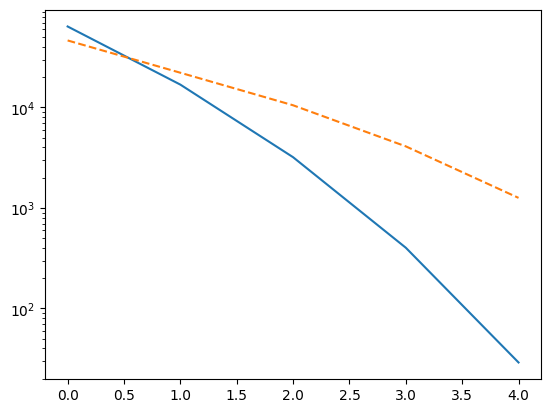

In [14]:
pl.figure()
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_high_Nhalo'])
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_high_Nhalo'], ls='--')
pl.yscale('log')




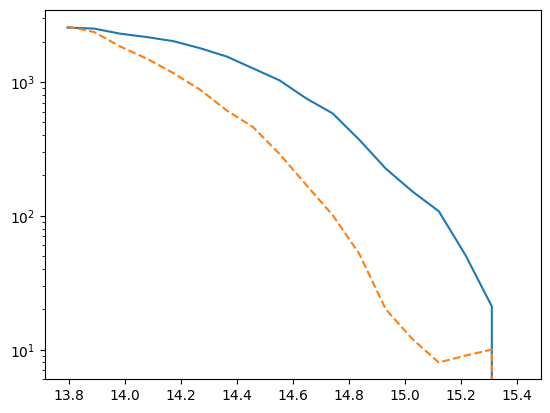

In [26]:
pl.figure()
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_high_Mhalo'][0,:])
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_high_Mhalo'][0,:], ls='--')
pl.yscale('log')




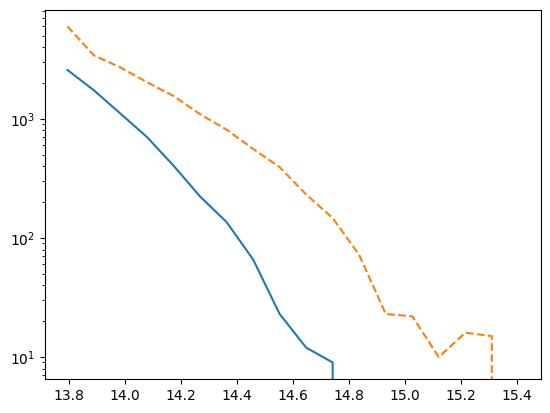

In [27]:
pl.figure()
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_all_Mhalo'][1,:])
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][1,:], ls='--')
pl.yscale('log')




In [15]:
sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
# load the halo data
fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
df_h_subvol = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h_subvol['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h_subvol['N_halos']

fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
df_h_full = pk.load(open(fname, 'rb'))
df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'], df_h_full['N_halos_combined']



In [16]:
df_Mh_all_truth_comb.shape

(128, 128, 128, 4)

In [17]:
df_Mh_all_truth.shape


(512, 16, 16, 16, 4)

In [14]:
fname


'/mnt/home/spandey/ceph/Quijote/data_NGP_self/1/halos_fof_lgMmincut_5e13_full_res_128_z=0.pk'